In [175]:
import pickle
from urllib.request import urlopen
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from nose.tools import *

import time
import datetime as dt
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm, skew, kurtosis

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import lightgbm as lgb

In [176]:
# dataset website: https://dev.meteostat.net/bulk/hourly.html#endpoints
# dataset 2020 https://bulk.meteostat.net/v2/hourly/2020/07156.csv.gz
# dataset 2021 https://bulk.meteostat.net/v2/hourly/2021/07156.csv.gz
# license https://dev.meteostat.net/terms.html#license

In [177]:
# external data
fin_ext_data = pd.read_csv(Path("Final_Files") / "external_data_no_cyc.csv")

In [178]:
data = pd.read_parquet(Path("data") / "train.parquet")

In [179]:
data1 = pd.read_parquet(Path("data") / "test.parquet")

In [180]:
fin_ext_data

,Unnamed: 0,date,temp,dwpt,rhum,prcp,wdir,wspd,pres,holiday,weekend,lockdown1,lockdown2,season,is_night
0,0,2020-01-01 00:00:00,0.8,-0.1,94,0.0,170.0,5.4,1032.5,1,0,0,0,3,1
1,1,2020-01-01 01:00:00,-0.7,-1.3,96,0.0,200.0,9.4,1032.2,1,0,0,0,3,1
2,2,2020-01-01 02:00:00,-0.3,-0.6,98,0.0,190.0,7.6,1032.2,1,0,0,0,3,1
3,3,2020-01-01 03:00:00,0.0,-0.3,98,0.0,220.0,5.4,1031.9,1,0,0,0,3,1
4,4,2020-01-01 04:00:00,0.3,0.0,98,0.0,210.0,7.6,1031.6,1,0,0,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17411,17411,2021-12-31 19:00:00,11.9,10.3,90,0.0,250.0,5.4,1026.5,0,0,0,0,3,0
17412,17412,2021-12-31 20:00:00,12.0,10.6,91,0.0,280.0,11.2,1026.6,0,0,0,0,3,1
17413,17413,2021-12-31 21:00:00,12.2,10.9,92,0.0,280.0,7.6,1026.6,0,0,0,0,3,1
17414,17414,2021-12-31 22:00:00,12.0,10.6,91,0.0,270.0,3.6,1026.7,0,0,0,0,3,1


In [181]:
fin_ext_data = fin_ext_data.drop(['Unnamed: 0'], axis=1)
fin_ext_data['date'] = pd.to_datetime(fin_ext_data['date'])

In [182]:
train_merged = data.merge(fin_ext_data, on='date')

In [183]:
test_merged = data1.merge(fin_ext_data, on='date')

In [184]:
data_tr = train_merged.sort_values(["date", "counter_name"])
y_train = data_tr["log_bike_count"].values
X_train = data_tr.drop(["log_bike_count", "bike_count"], axis=1)

In [185]:
data_ts = test_merged.sort_values(["date", "counter_name"])
y_test = data_ts["log_bike_count"].values
X_test = data_ts.drop(["log_bike_count", "bike_count"], axis=1)

In [186]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [187]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()
num_features = ['temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres']

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "season"]

rest_cols = ['holiday', 'weekend', 'is_night', 'lockdown1', 'lockdown2']

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("numf", StandardScaler(), num_features),
        ("rem", 'passthrough', rest_cols)
    ]
)

In [188]:
regressor = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=10,
        l2_leaf_reg=5,
        bootstrap_type = "Bayesian",
        bagging_temperature = 0.5,
        random_strength=5)


pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

0:	learn: 1.6217189	total: 291ms	remaining: 4m 50s
1:	learn: 1.5701810	total: 372ms	remaining: 3m 5s
2:	learn: 1.5246292	total: 461ms	remaining: 2m 33s
3:	learn: 1.4818970	total: 587ms	remaining: 2m 26s
4:	learn: 1.4395731	total: 681ms	remaining: 2m 15s
5:	learn: 1.3999572	total: 763ms	remaining: 2m 6s
6:	learn: 1.3657010	total: 867ms	remaining: 2m 2s
7:	learn: 1.3318273	total: 949ms	remaining: 1m 57s
8:	learn: 1.2993958	total: 1.05s	remaining: 1m 55s
9:	learn: 1.2681704	total: 1.24s	remaining: 2m 3s
10:	learn: 1.2381659	total: 1.37s	remaining: 2m 3s
11:	learn: 1.2136187	total: 1.5s	remaining: 2m 3s
12:	learn: 1.1913970	total: 1.59s	remaining: 2m
13:	learn: 1.1684954	total: 1.67s	remaining: 1m 57s
14:	learn: 1.1458414	total: 1.77s	remaining: 1m 56s
15:	learn: 1.1269516	total: 1.85s	remaining: 1m 53s
16:	learn: 1.1074419	total: 1.95s	remaining: 1m 52s
17:	learn: 1.0915242	total: 2.05s	remaining: 1m 51s
18:	learn: 1.0742008	total: 2.14s	remaining: 1m 50s
19:	learn: 1.0583644	total: 2.22s

160:	learn: 0.6296598	total: 15s	remaining: 1m 18s
161:	learn: 0.6290746	total: 15.1s	remaining: 1m 18s
162:	learn: 0.6277579	total: 15.2s	remaining: 1m 18s
163:	learn: 0.6271278	total: 15.3s	remaining: 1m 17s
164:	learn: 0.6256383	total: 15.4s	remaining: 1m 17s
165:	learn: 0.6251047	total: 15.4s	remaining: 1m 17s
166:	learn: 0.6244918	total: 15.5s	remaining: 1m 17s
167:	learn: 0.6233939	total: 15.6s	remaining: 1m 17s
168:	learn: 0.6221905	total: 15.7s	remaining: 1m 17s
169:	learn: 0.6216225	total: 15.8s	remaining: 1m 17s
170:	learn: 0.6208275	total: 15.9s	remaining: 1m 16s
171:	learn: 0.6195593	total: 15.9s	remaining: 1m 16s
172:	learn: 0.6188573	total: 16s	remaining: 1m 16s
173:	learn: 0.6182245	total: 16.1s	remaining: 1m 16s
174:	learn: 0.6174922	total: 16.2s	remaining: 1m 16s
175:	learn: 0.6168850	total: 16.3s	remaining: 1m 16s
176:	learn: 0.6163696	total: 16.4s	remaining: 1m 16s
177:	learn: 0.6159026	total: 16.4s	remaining: 1m 15s
178:	learn: 0.6149376	total: 16.5s	remaining: 1m 1

318:	learn: 0.5318110	total: 28.2s	remaining: 1m
319:	learn: 0.5313252	total: 28.3s	remaining: 1m
320:	learn: 0.5308849	total: 28.4s	remaining: 60s
321:	learn: 0.5303689	total: 28.4s	remaining: 59.9s
322:	learn: 0.5298424	total: 28.5s	remaining: 59.8s
323:	learn: 0.5291683	total: 28.6s	remaining: 59.7s
324:	learn: 0.5287880	total: 28.7s	remaining: 59.6s
325:	learn: 0.5283380	total: 28.8s	remaining: 59.5s
326:	learn: 0.5279216	total: 28.8s	remaining: 59.4s
327:	learn: 0.5275627	total: 28.9s	remaining: 59.3s
328:	learn: 0.5271023	total: 29s	remaining: 59.2s
329:	learn: 0.5266950	total: 29.1s	remaining: 59s
330:	learn: 0.5264039	total: 29.2s	remaining: 59s
331:	learn: 0.5261555	total: 29.3s	remaining: 58.9s
332:	learn: 0.5256971	total: 29.3s	remaining: 58.8s
333:	learn: 0.5253615	total: 29.4s	remaining: 58.7s
334:	learn: 0.5249765	total: 29.5s	remaining: 58.6s
335:	learn: 0.5246794	total: 29.6s	remaining: 58.5s
336:	learn: 0.5240883	total: 29.7s	remaining: 58.4s
337:	learn: 0.5236091	tota

479:	learn: 0.4783428	total: 44.2s	remaining: 47.9s
480:	learn: 0.4781908	total: 44.3s	remaining: 47.8s
481:	learn: 0.4778511	total: 44.4s	remaining: 47.7s
482:	learn: 0.4776461	total: 44.5s	remaining: 47.6s
483:	learn: 0.4774373	total: 44.6s	remaining: 47.5s
484:	learn: 0.4772117	total: 44.6s	remaining: 47.4s
485:	learn: 0.4769919	total: 44.7s	remaining: 47.3s
486:	learn: 0.4767241	total: 44.8s	remaining: 47.2s
487:	learn: 0.4764673	total: 44.9s	remaining: 47.1s
488:	learn: 0.4762756	total: 45s	remaining: 47s
489:	learn: 0.4759480	total: 45.1s	remaining: 46.9s
490:	learn: 0.4755377	total: 45.2s	remaining: 46.8s
491:	learn: 0.4752625	total: 45.3s	remaining: 46.8s
492:	learn: 0.4749800	total: 45.4s	remaining: 46.7s
493:	learn: 0.4747559	total: 45.5s	remaining: 46.6s
494:	learn: 0.4745126	total: 45.6s	remaining: 46.5s
495:	learn: 0.4741005	total: 45.7s	remaining: 46.4s
496:	learn: 0.4739240	total: 45.8s	remaining: 46.4s
497:	learn: 0.4735591	total: 45.9s	remaining: 46.3s
498:	learn: 0.47

640:	learn: 0.4461608	total: 1m	remaining: 34.1s
641:	learn: 0.4460356	total: 1m	remaining: 34s
642:	learn: 0.4457986	total: 1m 1s	remaining: 33.9s
643:	learn: 0.4456572	total: 1m 1s	remaining: 33.8s
644:	learn: 0.4454630	total: 1m 1s	remaining: 33.7s
645:	learn: 0.4453414	total: 1m 1s	remaining: 33.7s
646:	learn: 0.4452014	total: 1m 1s	remaining: 33.6s
647:	learn: 0.4450133	total: 1m 1s	remaining: 33.5s
648:	learn: 0.4448781	total: 1m 1s	remaining: 33.4s
649:	learn: 0.4447366	total: 1m 1s	remaining: 33.3s
650:	learn: 0.4445563	total: 1m 1s	remaining: 33.2s
651:	learn: 0.4443581	total: 1m 2s	remaining: 33.1s
652:	learn: 0.4441220	total: 1m 2s	remaining: 33s
653:	learn: 0.4439583	total: 1m 2s	remaining: 32.9s
654:	learn: 0.4438384	total: 1m 2s	remaining: 32.9s
655:	learn: 0.4437308	total: 1m 2s	remaining: 32.8s
656:	learn: 0.4436164	total: 1m 2s	remaining: 32.7s
657:	learn: 0.4434653	total: 1m 2s	remaining: 32.6s
658:	learn: 0.4433427	total: 1m 2s	remaining: 32.5s
659:	learn: 0.4431794	

800:	learn: 0.4238350	total: 1m 15s	remaining: 18.6s
801:	learn: 0.4237231	total: 1m 15s	remaining: 18.5s
802:	learn: 0.4235988	total: 1m 15s	remaining: 18.4s
803:	learn: 0.4235097	total: 1m 15s	remaining: 18.3s
804:	learn: 0.4234257	total: 1m 15s	remaining: 18.2s
805:	learn: 0.4232988	total: 1m 15s	remaining: 18.1s
806:	learn: 0.4231927	total: 1m 15s	remaining: 18.1s
807:	learn: 0.4230904	total: 1m 15s	remaining: 18s
808:	learn: 0.4230104	total: 1m 15s	remaining: 17.9s
809:	learn: 0.4229059	total: 1m 15s	remaining: 17.8s
810:	learn: 0.4228046	total: 1m 15s	remaining: 17.7s
811:	learn: 0.4227138	total: 1m 15s	remaining: 17.6s
812:	learn: 0.4225443	total: 1m 15s	remaining: 17.5s
813:	learn: 0.4224586	total: 1m 16s	remaining: 17.4s
814:	learn: 0.4223574	total: 1m 16s	remaining: 17.3s
815:	learn: 0.4222849	total: 1m 16s	remaining: 17.2s
816:	learn: 0.4221811	total: 1m 16s	remaining: 17.1s
817:	learn: 0.4220367	total: 1m 16s	remaining: 17s
818:	learn: 0.4219304	total: 1m 16s	remaining: 16.

956:	learn: 0.4075257	total: 1m 27s	remaining: 3.95s
957:	learn: 0.4074675	total: 1m 27s	remaining: 3.85s
958:	learn: 0.4074038	total: 1m 27s	remaining: 3.76s
959:	learn: 0.4073361	total: 1m 28s	remaining: 3.67s
960:	learn: 0.4072200	total: 1m 28s	remaining: 3.58s
961:	learn: 0.4071037	total: 1m 28s	remaining: 3.48s
962:	learn: 0.4070406	total: 1m 28s	remaining: 3.39s
963:	learn: 0.4069668	total: 1m 28s	remaining: 3.3s
964:	learn: 0.4068680	total: 1m 28s	remaining: 3.21s
965:	learn: 0.4068038	total: 1m 28s	remaining: 3.12s
966:	learn: 0.4067112	total: 1m 28s	remaining: 3.02s
967:	learn: 0.4066244	total: 1m 28s	remaining: 2.93s
968:	learn: 0.4065451	total: 1m 28s	remaining: 2.84s
969:	learn: 0.4064620	total: 1m 28s	remaining: 2.75s
970:	learn: 0.4063896	total: 1m 28s	remaining: 2.66s
971:	learn: 0.4062940	total: 1m 29s	remaining: 2.56s
972:	learn: 0.4062248	total: 1m 29s	remaining: 2.47s
973:	learn: 0.4061616	total: 1m 29s	remaining: 2.38s
974:	learn: 0.4060589	total: 1m 29s	remaining: 

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x7f9d3a5731f0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'season']),
                                                 ('numf', StandardScaler(),
                                                  ['temp', 'dwpt', 'rhum',
                                                   'prcp', 'wdir', 'wspd',
                                                   'pres']),
                                                 ('rem', 'passthrough',
                                                  ['holiday', 'weekend',
                                                   'is_night', 'lockdown1',
                                                   'lockdown2'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x7f9d39df4250>)])

In [189]:
# We compute the train and test RMSE as well as the r2 score

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.7f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.7f}"
)

print(
    f"Train set, r2 score={r2_score(y_train, pipe.predict(X_train)):.7f}"
)
print(
    f"Test set, r2 score={r2_score(y_test, pipe.predict(X_test)):.7f}"
)

Train set, RMSE=0.4038377
Test set, RMSE=0.4500575
Train set, r2 score=0.9418844
Test set, r2 score=0.9021950


In [190]:
new_date_cols = pipe[1].named_transformers_["date"].get_feature_names_out(date_cols)
print(len(new_date_cols))

76


In [191]:
new_cat_cols = pipe[1].named_transformers_["cat"].get_feature_names_out(categorical_cols)
print(len(new_cat_cols))

90


In [192]:
num_features = ['temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres',
                'holiday', 'weekend', 'is_night', 'lockdown1', 'lockdown2']

In [193]:
all_cols = np.concatenate([new_date_cols, new_cat_cols, num_features])
len(all_cols)

178

In [194]:
coefs = pipe[2].feature_importances_.flatten()

In [195]:
# Zip coefficients and names together and make a DataFrame
zipped = zip(all_cols, coefs)
df_f = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df_f["abs_value"] = df_f["value"].apply(lambda x: abs(x))
df_f = df_f.sort_values("abs_value", ascending=False)

<ipython-input-196-4d0eeb775460>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)


Text(0.5, 0, 'Coef')

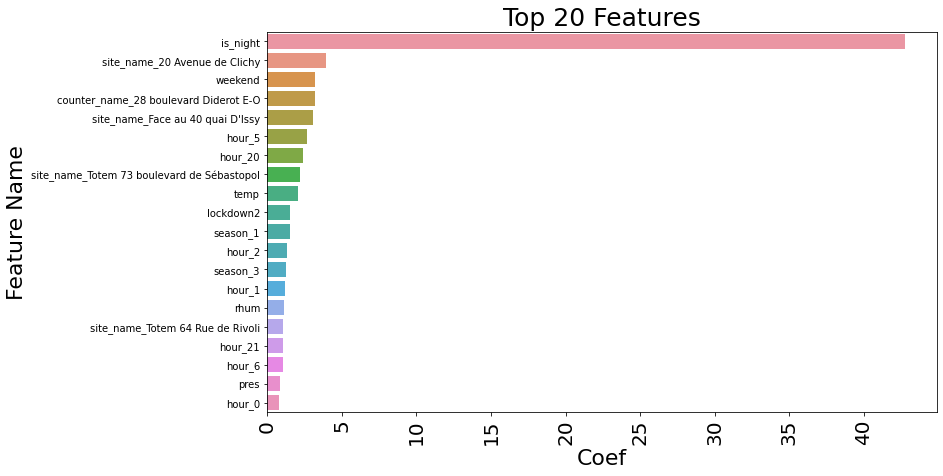

In [196]:
# plot the feature importance graphs
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="value",
            y="feature",
            data=df_f.head(20))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Feature Name", fontsize=22)
ax.set_xlabel("Coef", fontsize=22)

In [197]:
mask = (
    (X_test["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test["date"] > pd.to_datetime("2021/09/01"))
    & (X_test["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test[mask])) - 1

Text(0, 0.5, 'bike_count')

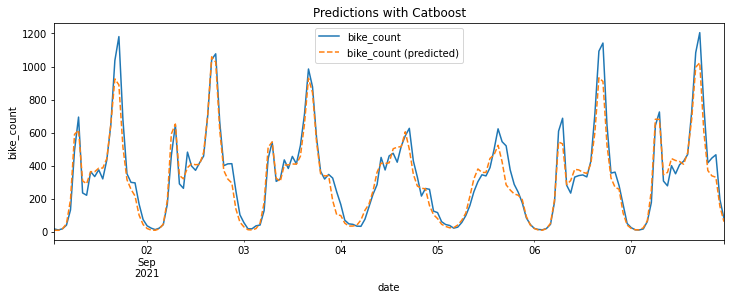

In [198]:
# plot to see the predicted bike count vs actual bike count
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Catboost")
ax.set_ylabel("bike_count")

In [199]:
regressor = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=10,
        l2_leaf_reg=10,
        bootstrap_type = "Bayesian",
        bagging_temperature = 0.5,
        random_strength=5)


pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

0:	learn: 1.6218271	total: 113ms	remaining: 1m 52s
1:	learn: 1.5703736	total: 211ms	remaining: 1m 45s
2:	learn: 1.5248903	total: 308ms	remaining: 1m 42s
3:	learn: 1.4822516	total: 421ms	remaining: 1m 44s
4:	learn: 1.4399931	total: 505ms	remaining: 1m 40s
5:	learn: 1.4007970	total: 586ms	remaining: 1m 37s
6:	learn: 1.3666255	total: 685ms	remaining: 1m 37s
7:	learn: 1.3322175	total: 763ms	remaining: 1m 34s
8:	learn: 1.2998442	total: 848ms	remaining: 1m 33s
9:	learn: 1.2687401	total: 941ms	remaining: 1m 33s
10:	learn: 1.2389041	total: 1.02s	remaining: 1m 31s
11:	learn: 1.2142817	total: 1.1s	remaining: 1m 30s
12:	learn: 1.1915914	total: 1.2s	remaining: 1m 31s
13:	learn: 1.1688674	total: 1.28s	remaining: 1m 30s
14:	learn: 1.1462516	total: 1.37s	remaining: 1m 29s
15:	learn: 1.1275340	total: 1.46s	remaining: 1m 29s
16:	learn: 1.1080931	total: 1.54s	remaining: 1m 28s
17:	learn: 1.0922202	total: 1.62s	remaining: 1m 28s
18:	learn: 1.0749567	total: 1.72s	remaining: 1m 28s
19:	learn: 1.0591789	tot

159:	learn: 0.6307159	total: 13.8s	remaining: 1m 12s
160:	learn: 0.6298493	total: 13.9s	remaining: 1m 12s
161:	learn: 0.6291277	total: 14s	remaining: 1m 12s
162:	learn: 0.6283080	total: 14s	remaining: 1m 12s
163:	learn: 0.6278280	total: 14.1s	remaining: 1m 12s
164:	learn: 0.6261687	total: 14.2s	remaining: 1m 11s
165:	learn: 0.6256591	total: 14.3s	remaining: 1m 11s
166:	learn: 0.6245019	total: 14.4s	remaining: 1m 11s
167:	learn: 0.6236559	total: 14.4s	remaining: 1m 11s
168:	learn: 0.6230877	total: 14.5s	remaining: 1m 11s
169:	learn: 0.6223906	total: 14.6s	remaining: 1m 11s
170:	learn: 0.6213534	total: 14.7s	remaining: 1m 11s
171:	learn: 0.6207530	total: 14.8s	remaining: 1m 11s
172:	learn: 0.6197546	total: 14.9s	remaining: 1m 11s
173:	learn: 0.6191032	total: 14.9s	remaining: 1m 10s
174:	learn: 0.6183668	total: 15s	remaining: 1m 10s
175:	learn: 0.6177594	total: 15.1s	remaining: 1m 10s
176:	learn: 0.6172625	total: 15.2s	remaining: 1m 10s
177:	learn: 0.6168205	total: 15.3s	remaining: 1m 10s

320:	learn: 0.5332396	total: 28.4s	remaining: 1m
321:	learn: 0.5328388	total: 28.5s	remaining: 1m
322:	learn: 0.5323138	total: 28.6s	remaining: 59.9s
323:	learn: 0.5319978	total: 28.7s	remaining: 59.9s
324:	learn: 0.5316103	total: 28.8s	remaining: 59.7s
325:	learn: 0.5312679	total: 28.8s	remaining: 59.6s
326:	learn: 0.5308501	total: 28.9s	remaining: 59.6s
327:	learn: 0.5303120	total: 29s	remaining: 59.5s
328:	learn: 0.5299655	total: 29.1s	remaining: 59.4s
329:	learn: 0.5296007	total: 29.2s	remaining: 59.3s
330:	learn: 0.5289704	total: 29.3s	remaining: 59.2s
331:	learn: 0.5286912	total: 29.4s	remaining: 59.1s
332:	learn: 0.5282124	total: 29.4s	remaining: 59s
333:	learn: 0.5277533	total: 29.5s	remaining: 58.9s
334:	learn: 0.5274078	total: 29.6s	remaining: 58.8s
335:	learn: 0.5269392	total: 29.7s	remaining: 58.7s
336:	learn: 0.5266389	total: 29.8s	remaining: 58.6s
337:	learn: 0.5261321	total: 29.9s	remaining: 58.5s
338:	learn: 0.5257729	total: 30s	remaining: 58.4s
339:	learn: 0.5254115	to

481:	learn: 0.4811756	total: 42.8s	remaining: 46s
482:	learn: 0.4809770	total: 42.9s	remaining: 45.9s
483:	learn: 0.4807086	total: 43s	remaining: 45.8s
484:	learn: 0.4804672	total: 43.1s	remaining: 45.8s
485:	learn: 0.4802069	total: 43.2s	remaining: 45.7s
486:	learn: 0.4800240	total: 43.3s	remaining: 45.6s
487:	learn: 0.4797780	total: 43.4s	remaining: 45.5s
488:	learn: 0.4794803	total: 43.4s	remaining: 45.4s
489:	learn: 0.4793246	total: 43.5s	remaining: 45.3s
490:	learn: 0.4790997	total: 43.6s	remaining: 45.2s
491:	learn: 0.4788636	total: 43.7s	remaining: 45.1s
492:	learn: 0.4786197	total: 43.8s	remaining: 45s
493:	learn: 0.4783554	total: 43.9s	remaining: 44.9s
494:	learn: 0.4781419	total: 43.9s	remaining: 44.8s
495:	learn: 0.4779415	total: 44s	remaining: 44.7s
496:	learn: 0.4777569	total: 44.1s	remaining: 44.7s
497:	learn: 0.4774377	total: 44.2s	remaining: 44.6s
498:	learn: 0.4772232	total: 44.3s	remaining: 44.5s
499:	learn: 0.4770526	total: 44.4s	remaining: 44.4s
500:	learn: 0.476824

640:	learn: 0.4498890	total: 57.2s	remaining: 32s
641:	learn: 0.4497621	total: 57.3s	remaining: 31.9s
642:	learn: 0.4494881	total: 57.3s	remaining: 31.8s
643:	learn: 0.4493483	total: 57.4s	remaining: 31.7s
644:	learn: 0.4491291	total: 57.5s	remaining: 31.6s
645:	learn: 0.4490196	total: 57.6s	remaining: 31.5s
646:	learn: 0.4488908	total: 57.7s	remaining: 31.5s
647:	learn: 0.4487228	total: 57.7s	remaining: 31.4s
648:	learn: 0.4485754	total: 57.8s	remaining: 31.3s
649:	learn: 0.4484547	total: 57.9s	remaining: 31.2s
650:	learn: 0.4483314	total: 58s	remaining: 31.1s
651:	learn: 0.4481242	total: 58.1s	remaining: 31s
652:	learn: 0.4479316	total: 58.1s	remaining: 30.9s
653:	learn: 0.4477913	total: 58.2s	remaining: 30.8s
654:	learn: 0.4476595	total: 58.3s	remaining: 30.7s
655:	learn: 0.4475059	total: 58.4s	remaining: 30.6s
656:	learn: 0.4473243	total: 58.5s	remaining: 30.5s
657:	learn: 0.4471750	total: 58.6s	remaining: 30.5s
658:	learn: 0.4470342	total: 58.7s	remaining: 30.4s
659:	learn: 0.4469

799:	learn: 0.4279259	total: 1m 10s	remaining: 17.7s
800:	learn: 0.4277845	total: 1m 11s	remaining: 17.7s
801:	learn: 0.4276745	total: 1m 11s	remaining: 17.6s
802:	learn: 0.4275826	total: 1m 11s	remaining: 17.5s
803:	learn: 0.4274652	total: 1m 11s	remaining: 17.4s
804:	learn: 0.4273412	total: 1m 11s	remaining: 17.3s
805:	learn: 0.4272077	total: 1m 11s	remaining: 17.2s
806:	learn: 0.4271082	total: 1m 11s	remaining: 17.1s
807:	learn: 0.4269111	total: 1m 11s	remaining: 17s
808:	learn: 0.4268002	total: 1m 11s	remaining: 16.9s
809:	learn: 0.4266454	total: 1m 11s	remaining: 16.8s
810:	learn: 0.4265495	total: 1m 11s	remaining: 16.7s
811:	learn: 0.4264485	total: 1m 11s	remaining: 16.7s
812:	learn: 0.4263498	total: 1m 12s	remaining: 16.6s
813:	learn: 0.4262880	total: 1m 12s	remaining: 16.5s
814:	learn: 0.4261659	total: 1m 12s	remaining: 16.4s
815:	learn: 0.4260616	total: 1m 12s	remaining: 16.3s
816:	learn: 0.4259735	total: 1m 12s	remaining: 16.2s
817:	learn: 0.4258443	total: 1m 12s	remaining: 1

955:	learn: 0.4115805	total: 1m 23s	remaining: 3.85s
956:	learn: 0.4115010	total: 1m 23s	remaining: 3.76s
957:	learn: 0.4114341	total: 1m 23s	remaining: 3.67s
958:	learn: 0.4113736	total: 1m 23s	remaining: 3.58s
959:	learn: 0.4113080	total: 1m 23s	remaining: 3.5s
960:	learn: 0.4112387	total: 1m 23s	remaining: 3.41s
961:	learn: 0.4111728	total: 1m 24s	remaining: 3.32s
962:	learn: 0.4111099	total: 1m 24s	remaining: 3.23s
963:	learn: 0.4110354	total: 1m 24s	remaining: 3.15s
964:	learn: 0.4109473	total: 1m 24s	remaining: 3.06s
965:	learn: 0.4108687	total: 1m 24s	remaining: 2.97s
966:	learn: 0.4107806	total: 1m 24s	remaining: 2.88s
967:	learn: 0.4107164	total: 1m 24s	remaining: 2.79s
968:	learn: 0.4106555	total: 1m 24s	remaining: 2.71s
969:	learn: 0.4105443	total: 1m 24s	remaining: 2.62s
970:	learn: 0.4104835	total: 1m 24s	remaining: 2.53s
971:	learn: 0.4103944	total: 1m 24s	remaining: 2.44s
972:	learn: 0.4102986	total: 1m 24s	remaining: 2.36s
973:	learn: 0.4101967	total: 1m 25s	remaining: 

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x7f9d3a5731f0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'season']),
                                                 ('numf', StandardScaler(),
                                                  ['temp', 'dwpt', 'rhum',
                                                   'prcp', 'wdir', 'wspd',
                                                   'pres']),
                                                 ('rem', 'passthrough',
                                                  ['holiday', 'weekend',
                                                   'is_night', 'lockdown1',
                                                   'lockdown2'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x7f9d38ae0070>)])

In [200]:
# We compute the train and test RMSE as well as the r2 score

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.7f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.7f}"
)

print(
    f"Train set, r2 score={r2_score(y_train, pipe.predict(X_train)):.7f}"
)
print(
    f"Test set, r2 score={r2_score(y_test, pipe.predict(X_test)):.7f}"
)

Train set, RMSE=0.4078541
Test set, RMSE=0.4538810
Train set, r2 score=0.9407227
Test set, r2 score=0.9005261


In [201]:
new_date_cols = pipe[1].named_transformers_["date"].get_feature_names_out(date_cols)
print(len(new_date_cols))

76


In [202]:
new_cat_cols = pipe[1].named_transformers_["cat"].get_feature_names_out(categorical_cols)
print(len(new_cat_cols))

90


In [203]:
all_cols = np.concatenate([new_date_cols, new_cat_cols, num_features])
len(all_cols)

178

In [204]:
coefs = pipe[2].feature_importances_.flatten()

In [205]:
# Zip coefficients and names together and make a DataFrame
zipped = zip(all_cols, coefs)
df_f = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df_f["abs_value"] = df_f["value"].apply(lambda x: abs(x))
df_f = df_f.sort_values("abs_value", ascending=False)

<ipython-input-206-859777fe36a9>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)


Text(0.5, 0, 'Coef')

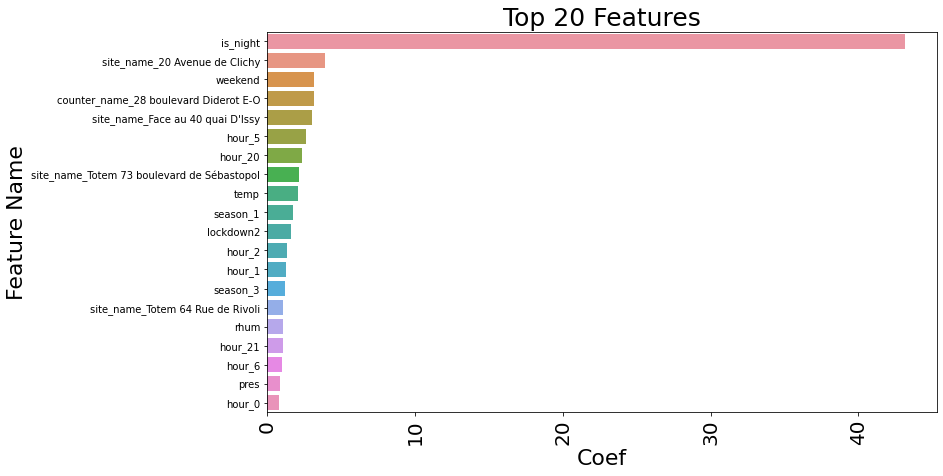

In [206]:
# plot the feature importance graphs
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="value",
            y="feature",
            data=df_f.head(20))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Feature Name", fontsize=22)
ax.set_xlabel("Coef", fontsize=22)

In [207]:
mask = (
    (X_test["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test["date"] > pd.to_datetime("2021/09/01"))
    & (X_test["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test[mask])) - 1

Text(0, 0.5, 'bike_count')

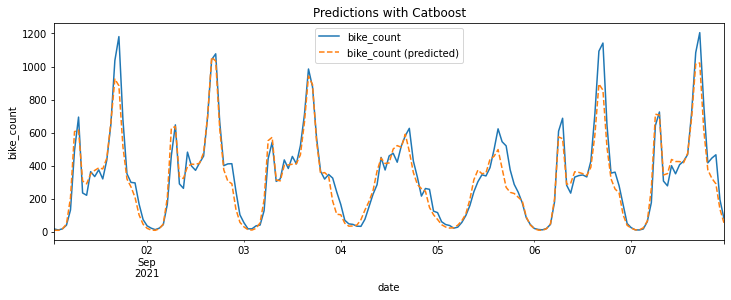

In [208]:
# plot to see the predicted bike count vs actual bike count
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Catboost")
ax.set_ylabel("bike_count")

In [209]:
regressor = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=8,
        l2_leaf_reg=7,
        bootstrap_type = "Bayesian",
        bagging_temperature = 0.3,
        random_strength=3)

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

0:	learn: 1.5677310	total: 39.8ms	remaining: 39.7s
1:	learn: 1.4764980	total: 83.2ms	remaining: 41.5s
2:	learn: 1.3997380	total: 118ms	remaining: 39.3s
3:	learn: 1.3263007	total: 151ms	remaining: 37.6s
4:	learn: 1.2642718	total: 186ms	remaining: 37s
5:	learn: 1.2143574	total: 224ms	remaining: 37s
6:	learn: 1.1678459	total: 276ms	remaining: 39.1s
7:	learn: 1.1299640	total: 320ms	remaining: 39.7s
8:	learn: 1.0949819	total: 357ms	remaining: 39.3s
9:	learn: 1.0640539	total: 391ms	remaining: 38.7s
10:	learn: 1.0377206	total: 426ms	remaining: 38.3s
11:	learn: 1.0120365	total: 503ms	remaining: 41.4s
12:	learn: 0.9941619	total: 563ms	remaining: 42.7s
13:	learn: 0.9767420	total: 605ms	remaining: 42.6s
14:	learn: 0.9597303	total: 638ms	remaining: 41.9s
15:	learn: 0.9405694	total: 679ms	remaining: 41.8s
16:	learn: 0.9280101	total: 722ms	remaining: 41.7s
17:	learn: 0.9167369	total: 760ms	remaining: 41.5s
18:	learn: 0.9037391	total: 799ms	remaining: 41.3s
19:	learn: 0.8938881	total: 836ms	remaining

165:	learn: 0.5578490	total: 5.99s	remaining: 30.1s
166:	learn: 0.5570652	total: 6.02s	remaining: 30s
167:	learn: 0.5563330	total: 6.05s	remaining: 30s
168:	learn: 0.5555820	total: 6.09s	remaining: 29.9s
169:	learn: 0.5550486	total: 6.12s	remaining: 29.9s
170:	learn: 0.5545440	total: 6.15s	remaining: 29.8s
171:	learn: 0.5536154	total: 6.19s	remaining: 29.8s
172:	learn: 0.5531382	total: 6.22s	remaining: 29.8s
173:	learn: 0.5525420	total: 6.26s	remaining: 29.7s
174:	learn: 0.5516001	total: 6.29s	remaining: 29.7s
175:	learn: 0.5507459	total: 6.33s	remaining: 29.6s
176:	learn: 0.5498346	total: 6.36s	remaining: 29.6s
177:	learn: 0.5488367	total: 6.39s	remaining: 29.5s
178:	learn: 0.5483398	total: 6.42s	remaining: 29.5s
179:	learn: 0.5476467	total: 6.46s	remaining: 29.4s
180:	learn: 0.5467242	total: 6.5s	remaining: 29.4s
181:	learn: 0.5459363	total: 6.53s	remaining: 29.4s
182:	learn: 0.5454331	total: 6.57s	remaining: 29.3s
183:	learn: 0.5450087	total: 6.6s	remaining: 29.3s
184:	learn: 0.5441

326:	learn: 0.4838994	total: 11.4s	remaining: 23.4s
327:	learn: 0.4834865	total: 11.4s	remaining: 23.4s
328:	learn: 0.4832281	total: 11.4s	remaining: 23.3s
329:	learn: 0.4830266	total: 11.5s	remaining: 23.3s
330:	learn: 0.4827506	total: 11.5s	remaining: 23.3s
331:	learn: 0.4823780	total: 11.5s	remaining: 23.2s
332:	learn: 0.4821116	total: 11.6s	remaining: 23.2s
333:	learn: 0.4817288	total: 11.6s	remaining: 23.2s
334:	learn: 0.4814645	total: 11.6s	remaining: 23.1s
335:	learn: 0.4811493	total: 11.7s	remaining: 23.1s
336:	learn: 0.4809117	total: 11.7s	remaining: 23s
337:	learn: 0.4806470	total: 11.7s	remaining: 23s
338:	learn: 0.4803910	total: 11.8s	remaining: 23s
339:	learn: 0.4801196	total: 11.8s	remaining: 22.9s
340:	learn: 0.4798495	total: 11.8s	remaining: 22.9s
341:	learn: 0.4791828	total: 11.9s	remaining: 22.8s
342:	learn: 0.4788280	total: 11.9s	remaining: 22.8s
343:	learn: 0.4785560	total: 11.9s	remaining: 22.8s
344:	learn: 0.4780368	total: 12s	remaining: 22.7s
345:	learn: 0.477833

485:	learn: 0.4468353	total: 16.8s	remaining: 17.7s
486:	learn: 0.4467032	total: 16.8s	remaining: 17.7s
487:	learn: 0.4464526	total: 16.9s	remaining: 17.7s
488:	learn: 0.4462819	total: 16.9s	remaining: 17.6s
489:	learn: 0.4461444	total: 16.9s	remaining: 17.6s
490:	learn: 0.4458671	total: 16.9s	remaining: 17.6s
491:	learn: 0.4457191	total: 17s	remaining: 17.5s
492:	learn: 0.4455890	total: 17s	remaining: 17.5s
493:	learn: 0.4454553	total: 17s	remaining: 17.5s
494:	learn: 0.4452880	total: 17.1s	remaining: 17.4s
495:	learn: 0.4451519	total: 17.1s	remaining: 17.4s
496:	learn: 0.4449943	total: 17.1s	remaining: 17.3s
497:	learn: 0.4448536	total: 17.2s	remaining: 17.3s
498:	learn: 0.4446727	total: 17.2s	remaining: 17.3s
499:	learn: 0.4445473	total: 17.2s	remaining: 17.2s
500:	learn: 0.4443952	total: 17.3s	remaining: 17.2s
501:	learn: 0.4442325	total: 17.3s	remaining: 17.2s
502:	learn: 0.4439404	total: 17.3s	remaining: 17.1s
503:	learn: 0.4437349	total: 17.4s	remaining: 17.1s
504:	learn: 0.4434

644:	learn: 0.4218466	total: 22.3s	remaining: 12.3s
645:	learn: 0.4216552	total: 22.4s	remaining: 12.3s
646:	learn: 0.4215452	total: 22.4s	remaining: 12.2s
647:	learn: 0.4214308	total: 22.5s	remaining: 12.2s
648:	learn: 0.4213535	total: 22.5s	remaining: 12.2s
649:	learn: 0.4212323	total: 22.6s	remaining: 12.2s
650:	learn: 0.4211243	total: 22.6s	remaining: 12.1s
651:	learn: 0.4209781	total: 22.6s	remaining: 12.1s
652:	learn: 0.4207276	total: 22.7s	remaining: 12.1s
653:	learn: 0.4206169	total: 22.7s	remaining: 12s
654:	learn: 0.4205119	total: 22.8s	remaining: 12s
655:	learn: 0.4203356	total: 22.8s	remaining: 12s
656:	learn: 0.4202440	total: 22.9s	remaining: 11.9s
657:	learn: 0.4201251	total: 22.9s	remaining: 11.9s
658:	learn: 0.4200333	total: 22.9s	remaining: 11.9s
659:	learn: 0.4198645	total: 23s	remaining: 11.8s
660:	learn: 0.4197509	total: 23s	remaining: 11.8s
661:	learn: 0.4196256	total: 23s	remaining: 11.8s
662:	learn: 0.4195086	total: 23.1s	remaining: 11.7s
663:	learn: 0.4193354	to

806:	learn: 0.4041974	total: 28.1s	remaining: 6.72s
807:	learn: 0.4041409	total: 28.1s	remaining: 6.69s
808:	learn: 0.4040752	total: 28.2s	remaining: 6.65s
809:	learn: 0.4039938	total: 28.2s	remaining: 6.62s
810:	learn: 0.4039339	total: 28.2s	remaining: 6.58s
811:	learn: 0.4038317	total: 28.3s	remaining: 6.55s
812:	learn: 0.4037557	total: 28.3s	remaining: 6.51s
813:	learn: 0.4036189	total: 28.4s	remaining: 6.48s
814:	learn: 0.4035430	total: 28.4s	remaining: 6.44s
815:	learn: 0.4034879	total: 28.4s	remaining: 6.41s
816:	learn: 0.4034039	total: 28.4s	remaining: 6.37s
817:	learn: 0.4033227	total: 28.5s	remaining: 6.34s
818:	learn: 0.4032486	total: 28.5s	remaining: 6.3s
819:	learn: 0.4031453	total: 28.6s	remaining: 6.27s
820:	learn: 0.4030353	total: 28.6s	remaining: 6.24s
821:	learn: 0.4029391	total: 28.6s	remaining: 6.2s
822:	learn: 0.4028534	total: 28.7s	remaining: 6.17s
823:	learn: 0.4027561	total: 28.7s	remaining: 6.13s
824:	learn: 0.4026684	total: 28.7s	remaining: 6.09s
825:	learn: 0.

970:	learn: 0.3909048	total: 33.7s	remaining: 1.01s
971:	learn: 0.3908140	total: 33.7s	remaining: 972ms
972:	learn: 0.3907407	total: 33.8s	remaining: 937ms
973:	learn: 0.3906805	total: 33.8s	remaining: 902ms
974:	learn: 0.3906211	total: 33.8s	remaining: 868ms
975:	learn: 0.3905597	total: 33.9s	remaining: 833ms
976:	learn: 0.3904696	total: 33.9s	remaining: 798ms
977:	learn: 0.3903773	total: 34s	remaining: 764ms
978:	learn: 0.3903237	total: 34s	remaining: 729ms
979:	learn: 0.3902367	total: 34s	remaining: 694ms
980:	learn: 0.3901654	total: 34s	remaining: 659ms
981:	learn: 0.3901075	total: 34.1s	remaining: 625ms
982:	learn: 0.3900749	total: 34.1s	remaining: 590ms
983:	learn: 0.3900079	total: 34.1s	remaining: 555ms
984:	learn: 0.3899498	total: 34.2s	remaining: 520ms
985:	learn: 0.3898954	total: 34.2s	remaining: 486ms
986:	learn: 0.3898408	total: 34.2s	remaining: 451ms
987:	learn: 0.3897925	total: 34.3s	remaining: 416ms
988:	learn: 0.3897436	total: 34.3s	remaining: 382ms
989:	learn: 0.389690

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x7f9d3a5731f0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'season']),
                                                 ('numf', StandardScaler(),
                                                  ['temp', 'dwpt', 'rhum',
                                                   'prcp', 'wdir', 'wspd',
                                                   'pres']),
                                                 ('rem', 'passthrough',
                                                  ['holiday', 'weekend',
                                                   'is_night', 'lockdown1',
                                                   'lockdown2'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x7f9d258b7a30>)])

In [210]:
# We compute the train and test RMSE as well as the r2 score

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.7f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.7f}"
)

print(
    f"Train set, r2 score={r2_score(y_train, pipe.predict(X_train)):.7f}"
)
print(
    f"Test set, r2 score={r2_score(y_test, pipe.predict(X_test)):.7f}"
)

Train set, RMSE=0.3891189
Test set, RMSE=0.4339319
Train set, r2 score=0.9460435
Test set, r2 score=0.9090782


In [211]:
new_date_cols = pipe[1].named_transformers_["date"].get_feature_names_out(date_cols)
print(len(new_date_cols))

76


In [212]:
new_cat_cols = pipe[1].named_transformers_["cat"].get_feature_names_out(categorical_cols)
print(len(new_cat_cols))

90


In [213]:
all_cols = np.concatenate([new_date_cols, new_cat_cols, num_features])
len(all_cols)

178

In [214]:
coefs = pipe[2].feature_importances_.flatten()

In [215]:
# Zip coefficients and names together and make a DataFrame
zipped = zip(all_cols, coefs)
df_f = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df_f["abs_value"] = df_f["value"].apply(lambda x: abs(x))
df_f = df_f.sort_values("abs_value", ascending=False)

<ipython-input-216-4d0eeb775460>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)


Text(0.5, 0, 'Coef')

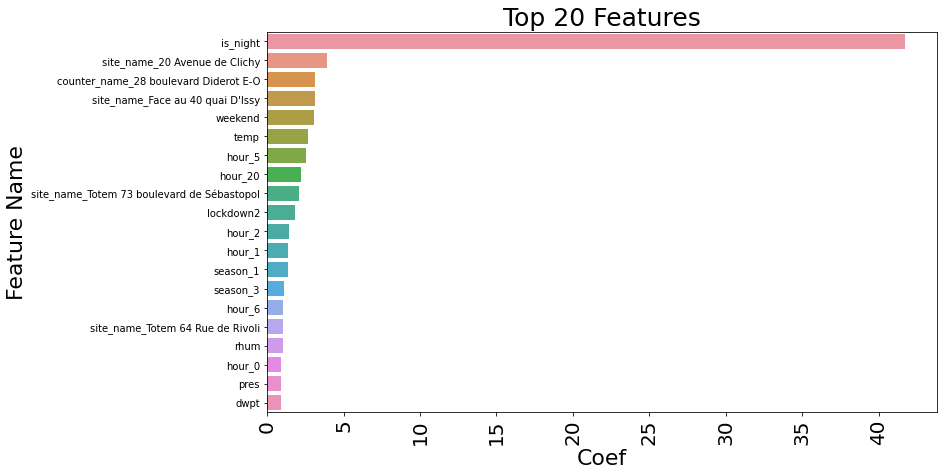

In [216]:
# plot the feature importance graphs
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="value",
            y="feature",
            data=df_f.head(20))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Feature Name", fontsize=22)
ax.set_xlabel("Coef", fontsize=22)

In [217]:
mask = (
    (X_test["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test["date"] > pd.to_datetime("2021/09/01"))
    & (X_test["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test[mask])) - 1

Text(0, 0.5, 'bike_count')

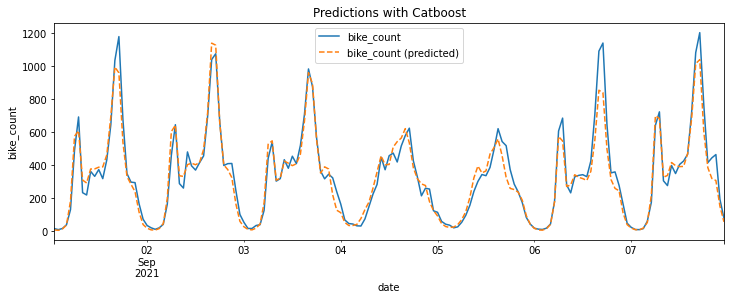

In [218]:
# plot to see the predicted bike count vs actual bike count
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Catboost")
ax.set_ylabel("bike_count")

In [219]:
regressor = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=8,
        l2_leaf_reg=10,
        bootstrap_type = "Bayesian",
        bagging_temperature = 0.3,
        random_strength=3)

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

0:	learn: 1.5678129	total: 38.4ms	remaining: 38.3s
1:	learn: 1.4766694	total: 77.5ms	remaining: 38.7s
2:	learn: 1.3999413	total: 115ms	remaining: 38.3s
3:	learn: 1.3265169	total: 148ms	remaining: 36.8s
4:	learn: 1.2644916	total: 183ms	remaining: 36.4s
5:	learn: 1.2146073	total: 219ms	remaining: 36.3s
6:	learn: 1.1680943	total: 290ms	remaining: 41.2s
7:	learn: 1.1302375	total: 349ms	remaining: 43.3s
8:	learn: 1.0952579	total: 397ms	remaining: 43.7s
9:	learn: 1.0643298	total: 436ms	remaining: 43.1s
10:	learn: 1.0379863	total: 472ms	remaining: 42.5s
11:	learn: 1.0123152	total: 519ms	remaining: 42.7s
12:	learn: 0.9944599	total: 555ms	remaining: 42.1s
13:	learn: 0.9770320	total: 589ms	remaining: 41.5s
14:	learn: 0.9600226	total: 623ms	remaining: 40.9s
15:	learn: 0.9408805	total: 658ms	remaining: 40.5s
16:	learn: 0.9280012	total: 690ms	remaining: 39.9s
17:	learn: 0.9168943	total: 730ms	remaining: 39.8s
18:	learn: 0.9052014	total: 777ms	remaining: 40.1s
19:	learn: 0.8955389	total: 810ms	remai

164:	learn: 0.5604595	total: 6.11s	remaining: 30.9s
165:	learn: 0.5598276	total: 6.15s	remaining: 30.9s
166:	learn: 0.5583078	total: 6.18s	remaining: 30.8s
167:	learn: 0.5572499	total: 6.21s	remaining: 30.8s
168:	learn: 0.5565923	total: 6.24s	remaining: 30.7s
169:	learn: 0.5560895	total: 6.28s	remaining: 30.6s
170:	learn: 0.5555481	total: 6.31s	remaining: 30.6s
171:	learn: 0.5548023	total: 6.35s	remaining: 30.6s
172:	learn: 0.5538362	total: 6.38s	remaining: 30.5s
173:	learn: 0.5531206	total: 6.41s	remaining: 30.4s
174:	learn: 0.5524218	total: 6.45s	remaining: 30.4s
175:	learn: 0.5515421	total: 6.48s	remaining: 30.3s
176:	learn: 0.5508923	total: 6.51s	remaining: 30.3s
177:	learn: 0.5502735	total: 6.55s	remaining: 30.2s
178:	learn: 0.5498315	total: 6.58s	remaining: 30.2s
179:	learn: 0.5488568	total: 6.62s	remaining: 30.1s
180:	learn: 0.5480176	total: 6.65s	remaining: 30.1s
181:	learn: 0.5474015	total: 6.68s	remaining: 30s
182:	learn: 0.5465968	total: 6.71s	remaining: 30s
183:	learn: 0.54

324:	learn: 0.4855063	total: 11.7s	remaining: 24.2s
325:	learn: 0.4851002	total: 11.7s	remaining: 24.2s
326:	learn: 0.4847596	total: 11.8s	remaining: 24.3s
327:	learn: 0.4843749	total: 11.8s	remaining: 24.3s
328:	learn: 0.4840523	total: 11.9s	remaining: 24.3s
329:	learn: 0.4836920	total: 12s	remaining: 24.3s
330:	learn: 0.4834471	total: 12s	remaining: 24.2s
331:	learn: 0.4831240	total: 12s	remaining: 24.2s
332:	learn: 0.4825491	total: 12.1s	remaining: 24.1s
333:	learn: 0.4823252	total: 12.1s	remaining: 24.1s
334:	learn: 0.4820357	total: 12.1s	remaining: 24.1s
335:	learn: 0.4816542	total: 12.2s	remaining: 24s
336:	learn: 0.4814115	total: 12.2s	remaining: 24s
337:	learn: 0.4812070	total: 12.2s	remaining: 23.9s
338:	learn: 0.4808948	total: 12.3s	remaining: 23.9s
339:	learn: 0.4805703	total: 12.3s	remaining: 23.9s
340:	learn: 0.4802933	total: 12.3s	remaining: 23.8s
341:	learn: 0.4800595	total: 12.4s	remaining: 23.8s
342:	learn: 0.4798397	total: 12.4s	remaining: 23.8s
343:	learn: 0.4795833	

487:	learn: 0.4476797	total: 18.6s	remaining: 19.5s
488:	learn: 0.4475274	total: 18.6s	remaining: 19.4s
489:	learn: 0.4473931	total: 18.6s	remaining: 19.4s
490:	learn: 0.4472143	total: 18.7s	remaining: 19.3s
491:	learn: 0.4470573	total: 18.7s	remaining: 19.3s
492:	learn: 0.4469115	total: 18.7s	remaining: 19.3s
493:	learn: 0.4467472	total: 18.8s	remaining: 19.2s
494:	learn: 0.4465409	total: 18.8s	remaining: 19.2s
495:	learn: 0.4462775	total: 18.8s	remaining: 19.1s
496:	learn: 0.4460814	total: 18.9s	remaining: 19.1s
497:	learn: 0.4459375	total: 18.9s	remaining: 19.1s
498:	learn: 0.4457911	total: 18.9s	remaining: 19s
499:	learn: 0.4454921	total: 19s	remaining: 19s
500:	learn: 0.4453453	total: 19s	remaining: 18.9s
501:	learn: 0.4452003	total: 19.1s	remaining: 18.9s
502:	learn: 0.4450686	total: 19.1s	remaining: 18.9s
503:	learn: 0.4449301	total: 19.1s	remaining: 18.8s
504:	learn: 0.4447005	total: 19.2s	remaining: 18.8s
505:	learn: 0.4445598	total: 19.2s	remaining: 18.7s
506:	learn: 0.444430

652:	learn: 0.4226485	total: 24.4s	remaining: 13s
653:	learn: 0.4225334	total: 24.4s	remaining: 12.9s
654:	learn: 0.4224402	total: 24.5s	remaining: 12.9s
655:	learn: 0.4222440	total: 24.5s	remaining: 12.8s
656:	learn: 0.4221007	total: 24.5s	remaining: 12.8s
657:	learn: 0.4219669	total: 24.6s	remaining: 12.8s
658:	learn: 0.4219146	total: 24.6s	remaining: 12.7s
659:	learn: 0.4217479	total: 24.6s	remaining: 12.7s
660:	learn: 0.4216231	total: 24.7s	remaining: 12.6s
661:	learn: 0.4215027	total: 24.7s	remaining: 12.6s
662:	learn: 0.4214079	total: 24.7s	remaining: 12.6s
663:	learn: 0.4213258	total: 24.8s	remaining: 12.5s
664:	learn: 0.4212362	total: 24.8s	remaining: 12.5s
665:	learn: 0.4209817	total: 24.8s	remaining: 12.4s
666:	learn: 0.4208675	total: 24.9s	remaining: 12.4s
667:	learn: 0.4207661	total: 24.9s	remaining: 12.4s
668:	learn: 0.4206695	total: 24.9s	remaining: 12.3s
669:	learn: 0.4205450	total: 24.9s	remaining: 12.3s
670:	learn: 0.4203874	total: 25s	remaining: 12.2s
671:	learn: 0.42

817:	learn: 0.4052205	total: 30.6s	remaining: 6.81s
818:	learn: 0.4051361	total: 30.6s	remaining: 6.77s
819:	learn: 0.4050512	total: 30.7s	remaining: 6.73s
820:	learn: 0.4048967	total: 30.7s	remaining: 6.69s
821:	learn: 0.4048168	total: 30.7s	remaining: 6.66s
822:	learn: 0.4047154	total: 30.8s	remaining: 6.62s
823:	learn: 0.4046346	total: 30.8s	remaining: 6.58s
824:	learn: 0.4045494	total: 30.8s	remaining: 6.54s
825:	learn: 0.4044634	total: 30.9s	remaining: 6.5s
826:	learn: 0.4043162	total: 30.9s	remaining: 6.46s
827:	learn: 0.4042562	total: 30.9s	remaining: 6.43s
828:	learn: 0.4040920	total: 31s	remaining: 6.39s
829:	learn: 0.4040266	total: 31s	remaining: 6.35s
830:	learn: 0.4039256	total: 31s	remaining: 6.31s
831:	learn: 0.4038571	total: 31.1s	remaining: 6.28s
832:	learn: 0.4037920	total: 31.1s	remaining: 6.24s
833:	learn: 0.4037303	total: 31.1s	remaining: 6.2s
834:	learn: 0.4036600	total: 31.2s	remaining: 6.16s
835:	learn: 0.4035852	total: 31.2s	remaining: 6.12s
836:	learn: 0.403486

976:	learn: 0.3928494	total: 36s	remaining: 847ms
977:	learn: 0.3927725	total: 36s	remaining: 810ms
978:	learn: 0.3927162	total: 36.1s	remaining: 774ms
979:	learn: 0.3926585	total: 36.1s	remaining: 737ms
980:	learn: 0.3926016	total: 36.1s	remaining: 700ms
981:	learn: 0.3925196	total: 36.2s	remaining: 663ms
982:	learn: 0.3924693	total: 36.2s	remaining: 626ms
983:	learn: 0.3923629	total: 36.2s	remaining: 589ms
984:	learn: 0.3922986	total: 36.3s	remaining: 552ms
985:	learn: 0.3922458	total: 36.3s	remaining: 516ms
986:	learn: 0.3922093	total: 36.4s	remaining: 479ms
987:	learn: 0.3921584	total: 36.4s	remaining: 442ms
988:	learn: 0.3921169	total: 36.4s	remaining: 405ms
989:	learn: 0.3920600	total: 36.5s	remaining: 369ms
990:	learn: 0.3919910	total: 36.5s	remaining: 332ms
991:	learn: 0.3918869	total: 36.6s	remaining: 295ms
992:	learn: 0.3918329	total: 36.6s	remaining: 258ms
993:	learn: 0.3917692	total: 36.7s	remaining: 221ms
994:	learn: 0.3916928	total: 36.7s	remaining: 184ms
995:	learn: 0.39

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x7f9d3a5731f0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'season']),
                                                 ('numf', StandardScaler(),
                                                  ['temp', 'dwpt', 'rhum',
                                                   'prcp', 'wdir', 'wspd',
                                                   'pres']),
                                                 ('rem', 'passthrough',
                                                  ['holiday', 'weekend',
                                                   'is_night', 'lockdown1',
                                                   'lockdown2'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x7f9d259f7880>)])

In [220]:
# We compute the train and test RMSE as well as the r2 score

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.7f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.7f}"
)

print(
    f"Train set, r2 score={r2_score(y_train, pipe.predict(X_train)):.7f}"
)
print(
    f"Test set, r2 score={r2_score(y_test, pipe.predict(X_test)):.7f}"
)

Train set, RMSE=0.3912611
Test set, RMSE=0.4293721
Train set, r2 score=0.9454478
Test set, r2 score=0.9109789


In [221]:
new_date_cols = pipe[1].named_transformers_["date"].get_feature_names_out(date_cols)
print(len(new_date_cols))

76


In [222]:
new_cat_cols = pipe[1].named_transformers_["cat"].get_feature_names_out(categorical_cols)
print(len(new_cat_cols))

90


In [223]:
all_cols = np.concatenate([new_date_cols, new_cat_cols, num_features])
len(all_cols)

178

In [224]:
coefs = pipe[2].feature_importances_.flatten()

In [225]:
# Zip coefficients and names together and make a DataFrame
zipped = zip(all_cols, coefs)
df_f = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df_f["abs_value"] = df_f["value"].apply(lambda x: abs(x))
df_f = df_f.sort_values("abs_value", ascending=False)

<ipython-input-226-4d0eeb775460>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)


Text(0.5, 0, 'Coef')

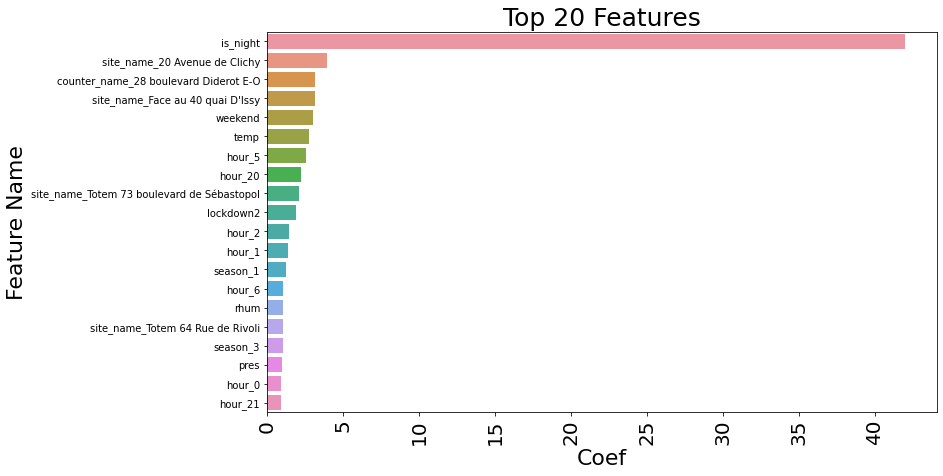

In [226]:
# plot the feature importance graphs
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="value",
            y="feature",
            data=df_f.head(20))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Feature Name", fontsize=22)
ax.set_xlabel("Coef", fontsize=22)

In [227]:
mask = (
    (X_test["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test["date"] > pd.to_datetime("2021/09/01"))
    & (X_test["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test[mask])) - 1

Text(0, 0.5, 'bike_count')

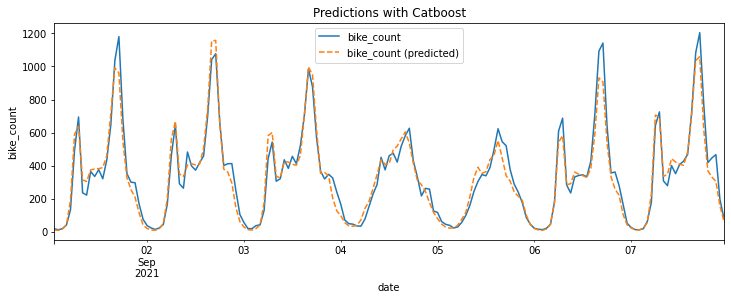

In [228]:
# plot to see the predicted bike count vs actual bike count
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Catboost")
ax.set_ylabel("bike_count")

In [229]:
regressor = XGBRegressor(
        colsample_bytree=0.4, eval_metric='rmse',
        gamma=0.3, learning_rate=0.1,
        max_cat_threshold=64, max_cat_to_onehot=4,
        max_depth=9, min_child_weight=3,
        n_estimators=200, random_state=0)

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x7f9d3a5731f0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'season']),
                                                 ('numf', StandardSc...
                              feature_types=None, gamma=0.3, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='', learning_rate=0.1,
                              max_bin=256, max_cat_threshold=64,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=9, max_leaves=0, min_child_weight=3,
                              missing=nan, monotone_constraints='()',
                              n_estimators=200, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, ...))])

In [230]:
# We compute the train and test RMSE as well as the r2 score

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.7f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.7f}"
)

print(
    f"Train set, r2 score={r2_score(y_train, pipe.predict(X_train)):.7f}"
)
print(
    f"Test set, r2 score={r2_score(y_test, pipe.predict(X_test)):.7f}"
)

Train set, RMSE=0.4207197
Test set, RMSE=0.4699504
Train set, r2 score=0.9369239
Test set, r2 score=0.8933578


In [231]:
new_date_cols = pipe[1].named_transformers_["date"].get_feature_names_out(date_cols)
print(len(new_date_cols))

76


In [232]:
new_cat_cols = pipe[1].named_transformers_["cat"].get_feature_names_out(categorical_cols)
print(len(new_cat_cols))

90


In [233]:
all_cols = np.concatenate([new_date_cols, new_cat_cols, num_features])
len(all_cols)

178

In [234]:
coefs = pipe[2].feature_importances_.flatten()

In [235]:
# Zip coefficients and names together and make a DataFrame
zipped = zip(all_cols, coefs)
df_f = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df_f["abs_value"] = df_f["value"].apply(lambda x: abs(x))
df_f = df_f.sort_values("abs_value", ascending=False)

<ipython-input-236-4d0eeb775460>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)


Text(0.5, 0, 'Coef')

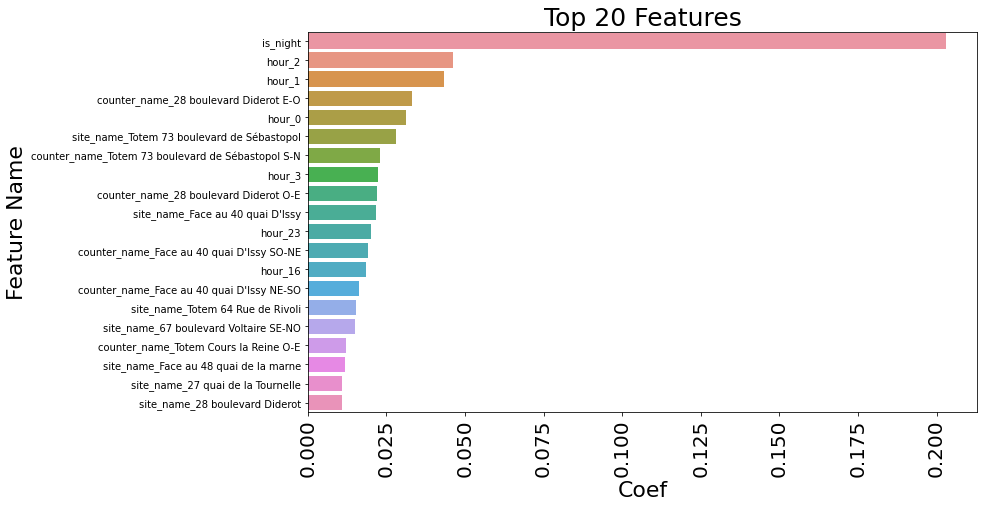

In [236]:
# plot the feature importance graphs
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="value",
            y="feature",
            data=df_f.head(20))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Feature Name", fontsize=22)
ax.set_xlabel("Coef", fontsize=22)

In [237]:
mask = (
    (X_test["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test["date"] > pd.to_datetime("2021/09/01"))
    & (X_test["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test[mask])) - 1

Text(0, 0.5, 'bike_count')

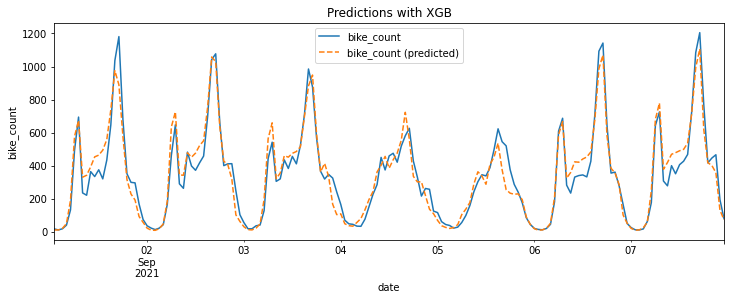

In [238]:
# plot to see the predicted bike count vs actual bike count
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with XGB")
ax.set_ylabel("bike_count")

In [239]:
regressor = XGBRegressor(
        colsample_bytree=0.4, eval_metric='rmse',
        gamma=0.5, learning_rate=0.05,
        max_cat_threshold=64, max_cat_to_onehot=4,
        max_depth=9, min_child_weight=4,
        n_estimators=200, subsample=0.5, random_state=0)

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x7f9d3a5731f0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'season']),
                                                 ('numf', StandardSc...
                              feature_types=None, gamma=0.5, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='', learning_rate=0.05,
                              max_bin=256, max_cat_threshold=64,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=9, max_leaves=0, min_child_weight=4,
                              missing=nan, monotone_constraints='()',
                              n_estimators=200, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, ...))])

In [240]:
# We compute the train and test RMSE as well as the r2 score

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.7f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.7f}"
)

print(
    f"Train set, r2 score={r2_score(y_train, pipe.predict(X_train)):.7f}"
)
print(
    f"Test set, r2 score={r2_score(y_test, pipe.predict(X_test)):.7f}"
)

Train set, RMSE=0.5193070
Test set, RMSE=0.5216378
Train set, r2 score=0.9038991
Test set, r2 score=0.8686097


In [241]:
new_date_cols = pipe[1].named_transformers_["date"].get_feature_names_out(date_cols)
print(len(new_date_cols))

76


In [242]:
new_cat_cols = pipe[1].named_transformers_["cat"].get_feature_names_out(categorical_cols)
print(len(new_cat_cols))

90


In [243]:
all_cols = np.concatenate([new_date_cols, new_cat_cols, num_features])
len(all_cols)

178

In [244]:
coefs = pipe[2].feature_importances_.flatten()

In [245]:
# Zip coefficients and names together and make a DataFrame
zipped = zip(all_cols, coefs)
df_f = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df_f["abs_value"] = df_f["value"].apply(lambda x: abs(x))
df_f = df_f.sort_values("abs_value", ascending=False)

<ipython-input-246-4d0eeb775460>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)


Text(0.5, 0, 'Coef')

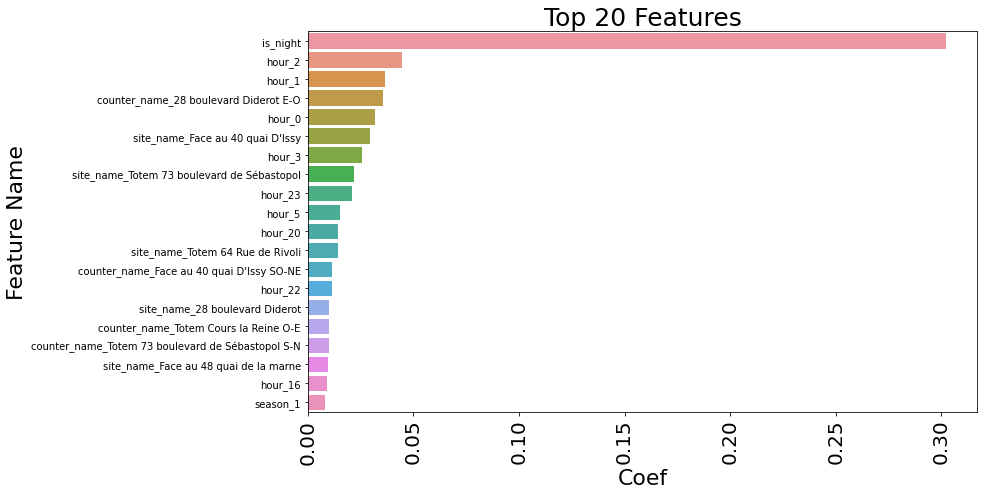

In [246]:
# plot the feature importance graphs
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="value",
            y="feature",
            data=df_f.head(20))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Feature Name", fontsize=22)
ax.set_xlabel("Coef", fontsize=22)

In [247]:
mask = (
    (X_test["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test["date"] > pd.to_datetime("2021/09/01"))
    & (X_test["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test[mask])) - 1

Text(0, 0.5, 'bike_count')

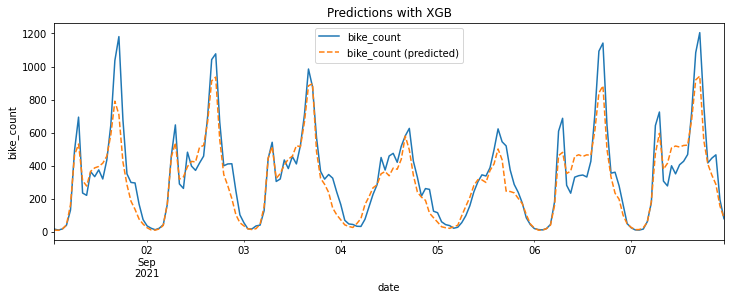

In [248]:
# plot to see the predicted bike count vs actual bike count
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with XGB")
ax.set_ylabel("bike_count")

In [249]:
regressor = XGBRegressor(
        colsample_bytree=0.7, eval_metric='rmse',
        gamma=0.4, learning_rate=0.1,
        max_cat_threshold=64, max_cat_to_onehot=4,
        max_depth=10, min_child_weight=7,
        n_estimators=500, random_state=0)

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x7f9d3a5731f0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'season']),
                                                 ('numf', StandardSc...
                              feature_types=None, gamma=0.4, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='', learning_rate=0.1,
                              max_bin=256, max_cat_threshold=64,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=10, max_leaves=0, min_child_weight=7,
                              missing=nan, monotone_constraints='()',
                              n_estimators=500, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, ...))])

In [250]:
# We compute the train and test RMSE as well as the r2 score

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.7f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.7f}"
)

print(
    f"Train set, r2 score={r2_score(y_train, pipe.predict(X_train)):.7f}"
)
print(
    f"Test set, r2 score={r2_score(y_test, pipe.predict(X_test)):.7f}"
)

Train set, RMSE=0.3151528
Test set, RMSE=0.4345230
Train set, r2 score=0.9646067
Test set, r2 score=0.9088303


In [251]:
new_date_cols = pipe[1].named_transformers_["date"].get_feature_names_out(date_cols)
print(len(new_date_cols))

76


In [252]:
new_cat_cols = pipe[1].named_transformers_["cat"].get_feature_names_out(categorical_cols)
print(len(new_cat_cols))

90


In [253]:
all_cols = np.concatenate([new_date_cols, new_cat_cols, num_features])
len(all_cols)

178

In [254]:
coefs = pipe[2].feature_importances_.flatten()

In [255]:
# Zip coefficients and names together and make a DataFrame
zipped = zip(all_cols, coefs)
df_f = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df_f["abs_value"] = df_f["value"].apply(lambda x: abs(x))
df_f = df_f.sort_values("abs_value", ascending=False)

<ipython-input-256-4d0eeb775460>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)


Text(0.5, 0, 'Coef')

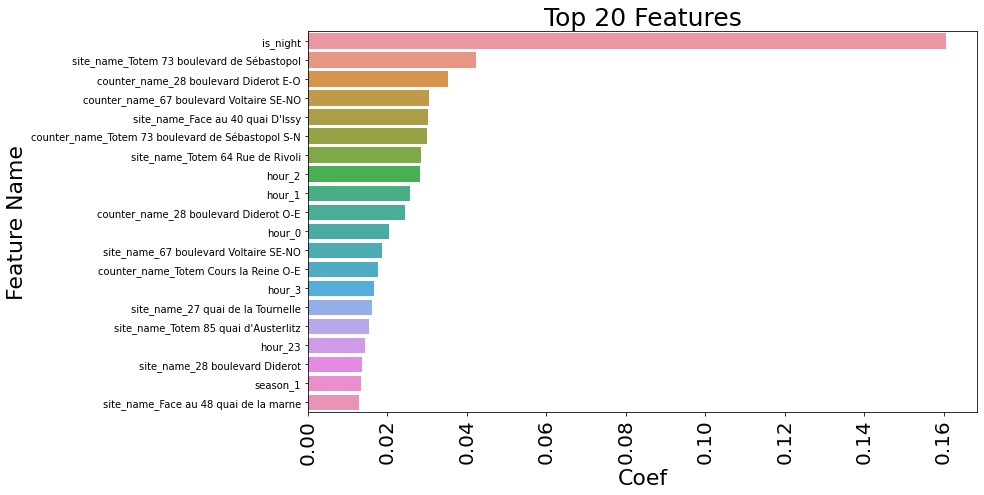

In [256]:
# plot the feature importance graphs
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="value",
            y="feature",
            data=df_f.head(20))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Feature Name", fontsize=22)
ax.set_xlabel("Coef", fontsize=22)

In [257]:
mask = (
    (X_test["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test["date"] > pd.to_datetime("2021/09/01"))
    & (X_test["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test[mask])) - 1

Text(0, 0.5, 'bike_count')

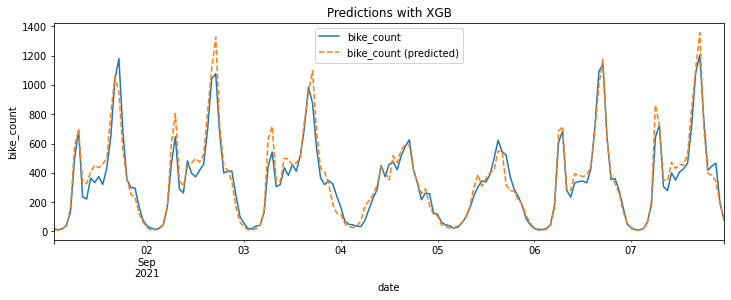

In [258]:
# plot to see the predicted bike count vs actual bike count
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with XGB")
ax.set_ylabel("bike_count")

In [259]:
regressor = LGBMRegressor(learning_rate=0.05, n_estimators=1000, colsample_bytree=0.7, reg_lambda=0.5)

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x7f9d3a5731f0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'season']),
                                                 ('numf', StandardScaler(),
                                                  ['temp', 'dwpt', 'rhum',
                                                   'prcp', 'wdir', 'wspd',
                                                   'pres']),
                                                 ('rem', 'passthrough',
                                                  ['holiday', 'weekend',
                                                   'is_night', 'lockdown1',
                                                   'lockdown2'])])),
                ('lgbmregressor',
                 LGBMRegressor(colsample_bytree=0.7, learning_rate=0.05,
                               n_estimators=1000, reg_lambda=0.5))])

In [260]:
# We compute the train and test RMSE as well as the r2 score

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.7f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.7f}"
)

print(
    f"Train set, r2 score={r2_score(y_train, pipe.predict(X_train)):.7f}"
)
print(
    f"Test set, r2 score={r2_score(y_test, pipe.predict(X_test)):.7f}"
)

Train set, RMSE=0.4337240
Test set, RMSE=0.4594709
Train set, r2 score=0.9329643
Test set, r2 score=0.8980608


In [261]:
new_date_cols = pipe[1].named_transformers_["date"].get_feature_names_out(date_cols)
print(len(new_date_cols))

76


In [262]:
new_cat_cols = pipe[1].named_transformers_["cat"].get_feature_names_out(categorical_cols)
print(len(new_cat_cols))

90


In [263]:
all_cols = np.concatenate([new_date_cols, new_cat_cols, num_features])
len(all_cols)

178

In [264]:
coefs = pipe[2].feature_importances_.flatten()

In [265]:
# Zip coefficients and names together and make a DataFrame
zipped = zip(all_cols, coefs)
df_f = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df_f["abs_value"] = df_f["value"].apply(lambda x: abs(x))
df_f = df_f.sort_values("abs_value", ascending=False)

<ipython-input-266-4d0eeb775460>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)


Text(0.5, 0, 'Coef')

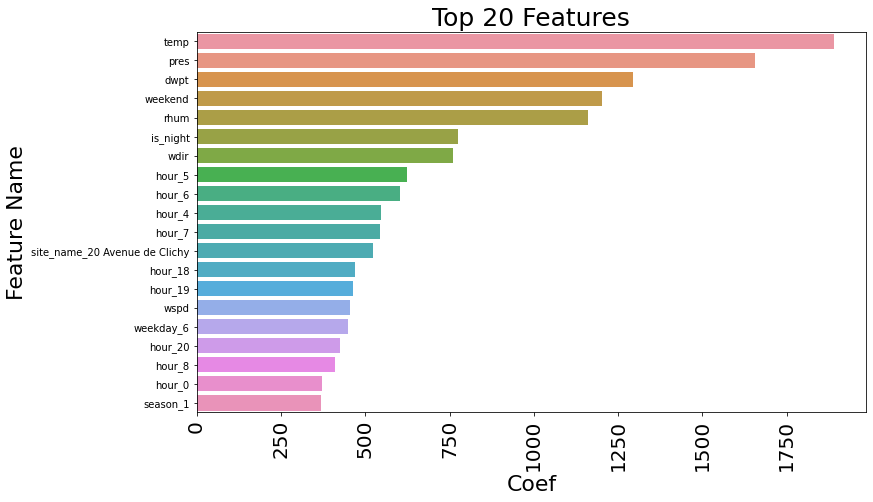

In [266]:
# plot the feature importance graphs
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="value",
            y="feature",
            data=df_f.head(20))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Feature Name", fontsize=22)
ax.set_xlabel("Coef", fontsize=22)

In [267]:
mask = (
    (X_test["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test["date"] > pd.to_datetime("2021/09/01"))
    & (X_test["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test[mask])) - 1

Text(0, 0.5, 'bike_count')

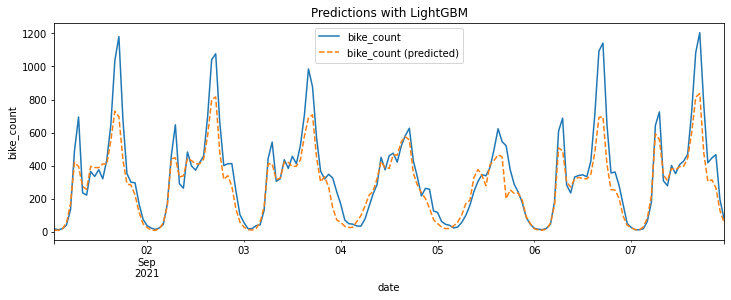

In [268]:
# plot to see the predicted bike count vs actual bike count
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with LightGBM")
ax.set_ylabel("bike_count")